# Data Scientist Professional Case Study

### Company Background

Inn the Neighborhood is an online platform that allows people to rent out their properties for short stays. At the moment, only 2% of people who come to the site interested in renting out their homes start to use it.

The product manager would like to increase this. They want to develop an application to help people estimate how much they could earn renting out their living space. They hope that this would make people more likely to sign up.



### Customer Question

The product manager would like to know:
- Can you develop a way to predict how much someone could earn from renting their property that could power the application?




### Success Criteria

They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.


### Dataset

The data you will use for this analysis can be accessed here: `"data/rentals.csv"`

### Overview of Features/Variables

Below are the 7 features + 1 target

<b>latitude</b>: latitude, makes up location coordinates

<b>longitude</b>: longitude, makes up location coordinates

<b>property_type</b>: indicates type of lodging, whether it is a house, apartment, RV or other (there are 26 categories)

<b>room_type</b>: indicates type of room, there are 4 categories: entire apt, private room, shared room, or hotel.

<b>bathrooms</b>: number of bathrooms.

<b>bedrooms</b>:  number of bedrooms, ranges from 0 to 6 bedrooms.

<b>minimum_nights</b>: minimum number of nights in order to rent the place, ranges from 1 to 100,000,000 nights (shown in line 8).

<b>price</b>: this is the target. The price ranges from $0 to $10,000 (shown in line 8).


In [ ]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!

### Importing Modules

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

import matplotlib.pyplot as plt
%matplotlib inline

### Reading the Data

In [ ]:
df_0 = pd.read_csv('data/rentals.csv')

In [ ]:
df_0.head()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00


### EDA: Data Understanding <br>
- Checking the shape of the dataframe <br>
- Generate an overview of the dataframe <br>
- Checking the data for null values <br>
- Check if the rows are duplicated in the dataframe
- Review <u>Descriptive Statistics</u> for data spread and outliers <br>

In [ ]:
df_0.shape

(8111, 9)

In [ ]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


##### Summary of Data Understanding
Based on the info shown above : <br>
(a) 9 different attributes, and the target is provided.<br>
(b) "id" is a column that can be omitted, "id" are typically randomly assigned, and should have no bearing on the target.<br>
(c) "price" is the target column, however, needs to be manipulated as it's currently being read as an object instead of a float type column.<br>
(d) "property_type" and "room_type" are features that are categorical, and need to be encoded to a numerical column type.<br>
(e) The data is best suited for a supervised machine learning algorithm , and should be a regression problem that predicts rental prices.

Most likely the following features will have to be preprocessed prior to loading into machine learning problem.

categorical_col = ["property_type", "room_type"] <br>
numerical_col = ["latitude","longitude","bathrooms","bedrooms","minimum_nights"]

In [ ]:
df_1 = df_0.copy()
df_1["price"] = df_1['price'].str.replace('$','').str.replace(',','').astype(float)

In [ ]:
#Checking for duplicated values
df_1.duplicated().sum()

0

In [ ]:
df_1.isnull().sum()

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
bathrooms         12
bedrooms           4
minimum_nights     0
price              0
dtype: int64

"bathrooms" and "bedrooms" contains null values.

There might be a way to infer "bathrooms" and "bedrooms" if we look at the pairwise correlation between all the variables. Let's look at this next under EDA (exploratory data analysis).

In [ ]:
df_1[df_1['bathrooms'].isnull() == True].groupby(['property_type','room_type'])['id'].count()

property_type  room_type      
Apartment      Entire home/apt    1
               Private room       5
Hostel         Shared room        6
Name: id, dtype: int64

Filling in the missing values for bathrooms with 0 also known as zero imputation, seems to make sense since majority of the missing values are due to shared room in a hostel, or private room in a shared apartment except for 1 unit. 

In [ ]:
df_1.loc[df_1['room_type'] != 'Entire home/apt', 'bathrooms'] = df_1.loc[df_1['room_type'] != 'Entire home/apt', 'bathrooms'].fillna(0)

In [ ]:
df_1[df_1['bedrooms'].isnull() == True].groupby(['property_type','room_type'])['id'].count()

property_type  room_type      
Apartment      Entire home/apt    3
House          Entire home/apt    1
Name: id, dtype: int64

Filling in the missing values for bedrooms can be done later on with either mean or median during the pipeline processing step. 

In [ ]:
df_1.describe()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,8.111000e+03,8111.000000,8111.000000,8110.000000,8107.000000,8.111000e+03,8111.000000
mean,2.024561e+07,37.766054,-122.430107,1.394081,1.345874,1.234526e+04,225.407101
std,1.228565e+07,0.022937,0.026967,0.924016,0.925298,1.110357e+06,412.253039
min,9.580000e+02,37.704630,-122.513060,0.000000,0.000000,1.000000e+00,0.000000
25%,8.905668e+06,37.751450,-122.442830,1.000000,1.000000,2.000000e+00,100.000000
50%,2.161057e+07,37.769150,-122.424650,1.000000,1.000000,4.000000e+00,150.000000
75%,3.120025e+07,37.785670,-122.410615,1.500000,2.000000,3.000000e+01,240.000000
max,3.935418e+07,37.828790,-122.368570,14.000000,14.000000,1.000000e+08,10000.000000


The standard deviation seems to be the highest for both "minimum_nights" and "price". 

The range for "minimum_nights" ranges from 0 to 10,000,000 minimum_nights, this seems to be an anomaly, but it may also be helpful to create a feature to differentiate between short-term rentals and long-term rentals. 

Let's look at possible outliers in the next step for "minimum_nights" and "price".

### EDA: Outliers<br>

Let's look at the boxpots for the following features identified in the previous step.

- minimum_nights (The descriptive statistics for minimum_nights showed a standard deviation of 1.110357e+06.<br>
- price

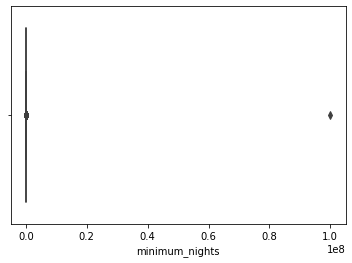

1 outlier input(s)


In [ ]:
ax = sns.boxplot(x=df_1["minimum_nights"])
plt.show()
print("{} outlier input(s)".format(len(df_1[df_1.minimum_nights>=10000000])))

The value of 100,000,000 night minimum does not make sense.

According to https://help.vrbo.com/articles/City-of-San-Francisco-Registration, a short-term rental is less than 30 nights.
And therefore a long-term rental would be considered equal to or more than 30 nights. 

This analysis is only for short-term, so let's exclude anything considered long-term. 

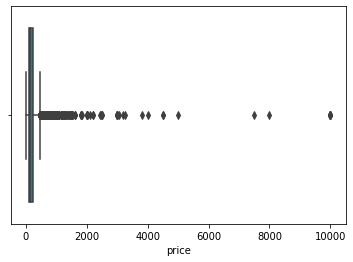

129 outlier input(s)


In [ ]:
ax = sns.boxplot(x=df_1["price"])
plt.show()
print("{} outlier input(s)".format(len(df_1[df_1.price>=1000])))

In [ ]:
#Remove Outliers

q_low = df_1["price"].quantile(0.02)
q_hi  = df_1["price"].quantile(0.98)

df_check = df_1[(df_1["price"] < q_hi) & (df_1["price"] > q_low)]

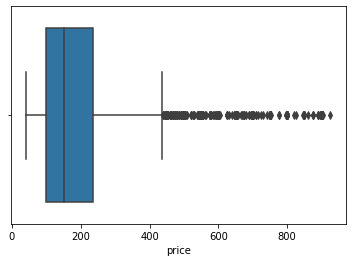

925.0 would be the new maximum price point, instead of $10,000


In [ ]:
ax = sns.boxplot(x=df_check["price"])
plt.show()
print("{} would be the new maximum price point, instead of $10,000".format(max(df_check["price"])))

Let's also exclude the outliers where the price seems to reflect greater than or equal to $1,000 nightly rate.

In [ ]:
df_2 = df_1.copy()
df_2 = df_2[(df_2["price"] < q_hi) & (df_2["price"] > q_low)]
df_2.drop(df_2[df_2.minimum_nights > 30].index, inplace = True)
df_2.head()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0
5,8339,37.77525,-122.43637,House,Entire home/apt,1.5,2.0,6,875.0
6,8739,37.75919,-122.42237,Condominium,Private room,1.0,1.0,1,139.0


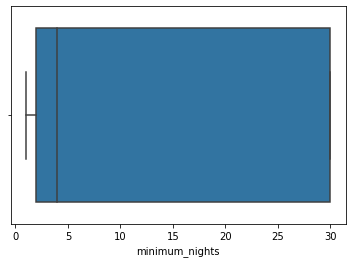

In [ ]:
ax = sns.boxplot(x=df_2["minimum_nights"])
plt.show()

### EDA: Analyzing the Feature Distribution

Let's look at the spread/distribution of the categorical columns using histograms.<br>

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'minimum_nights'}>],
       [<AxesSubplot:title={'center':'price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

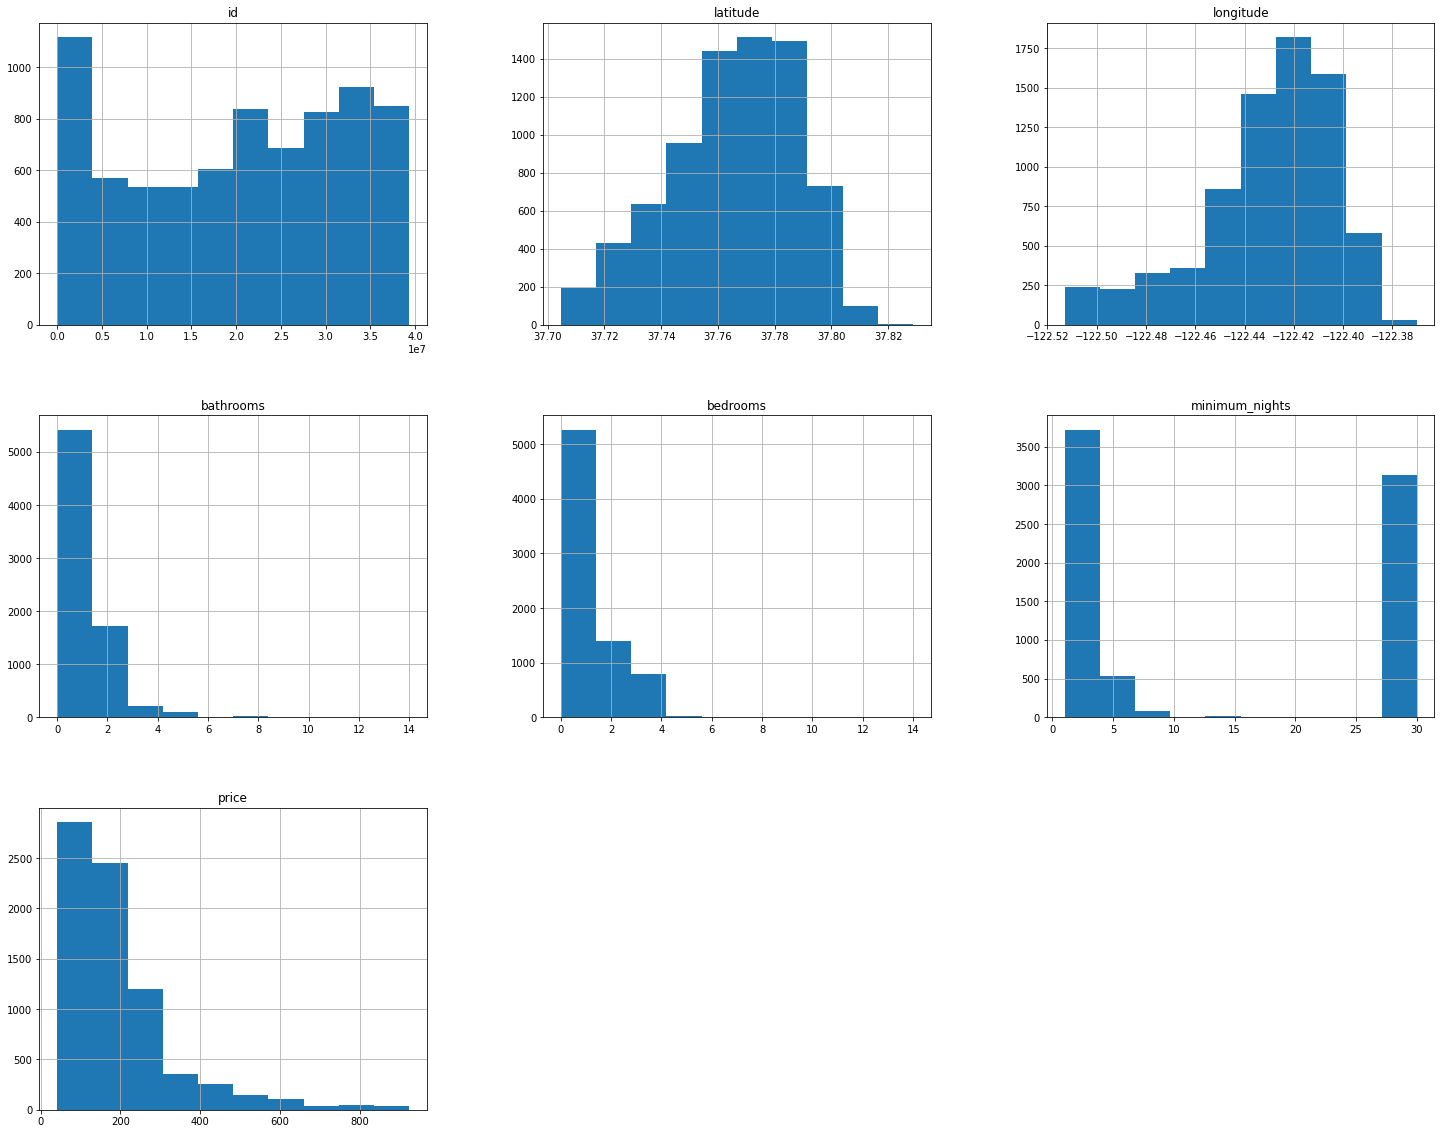

In [ ]:
df_2.hist(bins=10, figsize=(25, 20))

#### Diving Further Into Categorical Features <br>

In the descriptive statistics shown above, we were unable to gain any insight on the categorical variables: property_type and room_type.

##### property_type

Text(0.5, 1.0, 'Histogram of Property Types')

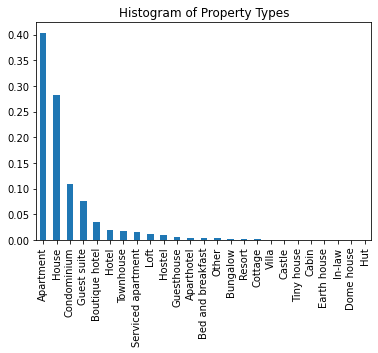

In [ ]:
#Diving further into the categorical variables: property_type
df_2['property_type'].value_counts(normalize=True).plot(kind='bar')
plt.title('Histogram of Property Types')

The above indicates that a majority of the rentals listed in the dataset are apartments (40%) and houses (over 25%).

##### room_type

Text(0.5, 1.0, 'Histogram of Room Type')

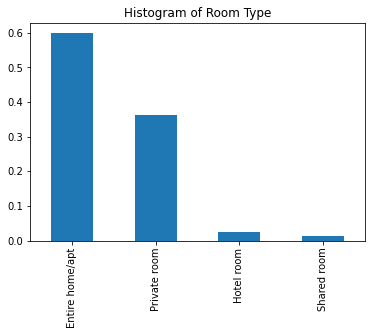

In [ ]:
df_2['room_type'].value_counts(normalize=True).plot(kind='bar')
plt.title('Histogram of Room Type')

Majority, nearly 60% of the room types are the entire home/apt or private rooms. 

#### Diving Further Into Location Coordinates <br>

Let's take a look at the spread of latitude and longitude simultaneously via a scatter chart. 

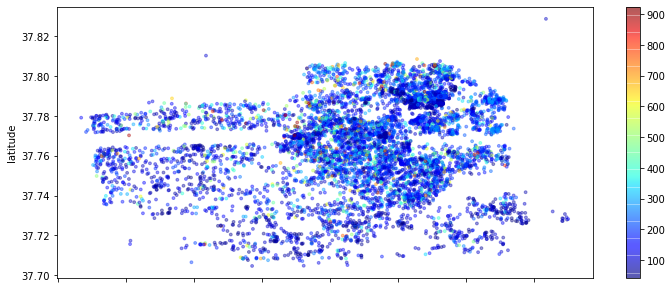

In [ ]:
df_2.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, c=df_2["price"], s=8, cmap=plt.get_cmap("jet"), figsize=(12,5))
plt.xlabel('longitude')
plt.show()

Text(0.5, 1.0, 'Histogram of Latitude')

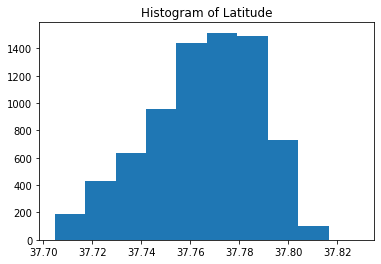

In [ ]:
plt.hist(df_2['latitude'], density=False, bins=10)
plt.title('Histogram of Latitude')

Text(0.5, 1.0, 'Histogram of Longitude')

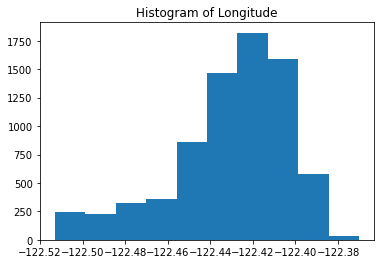

In [ ]:
plt.hist(df_2['longitude'], density=False, bins=10)
plt.title('Histogram of Longitude')

The longitude/latitude do not vary too much, seems concentrated in one area - the San Francisco/Bay Area.

Data from longitude and latitude may not give a lot of insight unless we convert latitude and longitude into neighborhoods.

According to renthop.com, there are over 20 different neighborhoods in the Bay Area. 
https://www.renthop.com/average-rent-in/san-francisco-bay-area-ca 

### Creating Regions with Clustering the Longitude and Latitude Using KMeans

In [ ]:
from sklearn.cluster import KMeans

### Visualizing the Elbow Curve

In [ ]:
distortions = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_2[["latitude","longitude","price"]])
    distortions.append(kmeanModel.inertia_)

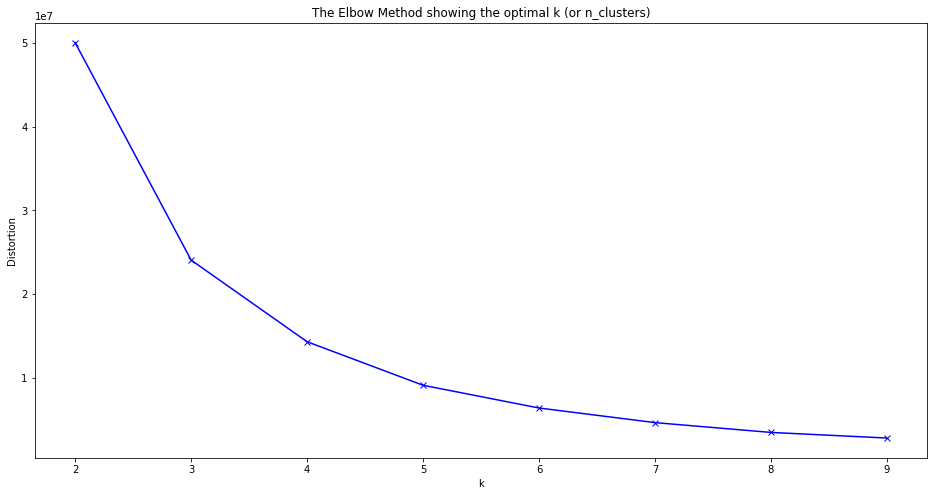

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k (or n_clusters)')
plt.show()

The elbow curve above shows that the optimal number of clusters for grouping latitude and longitude is 4.

In [ ]:
kmeans = KMeans(n_clusters=4)

In [ ]:
cluster = kmeans.fit(df_2[["latitude","longitude","price"]])

In [ ]:
df_2['cluster_label'] = kmeans.fit_predict(df_2[["latitude","longitude","price"]])

In [ ]:
df_2.groupby('cluster_label').count()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
cluster_label,,,,,,,,,
0,4084,4084,4084,4084,4084,4083,4081,4084,4084
1,727,727,727,727,727,727,727,727,727
2,233,233,233,233,233,233,232,233,233
3,2443,2443,2443,2443,2443,2443,2443,2443,2443


In [ ]:
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

In [ ]:
labels = df_2['cluster_label']

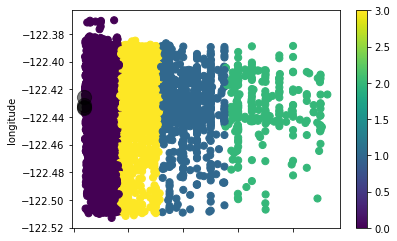

In [ ]:
df_2.plot.scatter(x = 'price', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
cluster_wo_price = kmeans.fit(df_2[["latitude","longitude"]])

In [ ]:
df_2['cluster_label_wo_price'] = kmeans.fit_predict(df_2[["latitude","longitude"]])

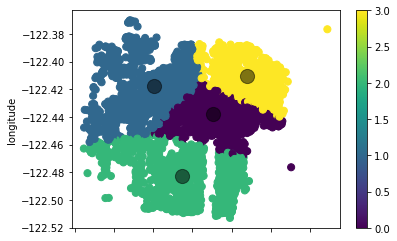

In [ ]:
centers_geo_only = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels_geo_only = df_2['cluster_label_wo_price']
df_2.plot.scatter(x = 'latitude', y = 'longitude', c=labels_geo_only, s=50, cmap='viridis')
plt.scatter(centers_geo_only[:, 0], centers_geo_only[:, 1], c='black', s=200, alpha=0.5)

### EDA: Correlation

In [ ]:
corr = df_2.corr()
display(corr)

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights,price,cluster_label,cluster_label_wo_price
id,1.000000,0.037629,0.055696,0.067225,-0.062388,0.090876,-0.024450,0.046337,0.154740
latitude,0.037629,1.000000,0.177327,0.060272,-0.131596,0.200968,0.125989,0.158147,0.396920
longitude,0.055696,0.177327,1.000000,0.000201,-0.118123,0.119935,0.023462,0.109977,0.214793
bathrooms,0.067225,0.060272,0.000201,1.000000,0.338842,0.048633,0.200045,0.042137,0.002611
bedrooms,-0.062388,-0.131596,-0.118123,0.338842,1.000000,-0.033181,0.574033,0.294807,-0.183377
minimum_nights,0.090876,0.200968,0.119935,0.048633,-0.033181,1.000000,-0.165183,-0.019155,0.090577
price,-0.024450,0.125989,0.023462,0.200045,0.574033,-0.165183,1.000000,0.445664,-0.049831
cluster_label,0.046337,0.158147,0.109977,0.042137,0.294807,-0.019155,0.445664,1.000000,0.054854
cluster_label_wo_price,0.154740,0.396920,0.214793,0.002611,-0.183377,0.090577,-0.049831,0.054854,1.000000


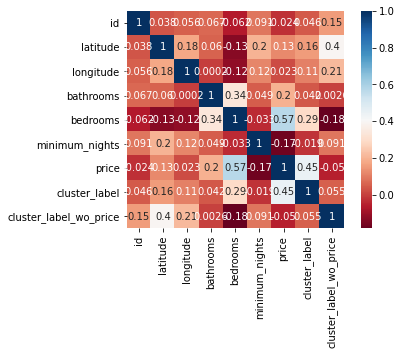

In [ ]:
sns.heatmap(corr, cmap="RdBu", square=True, annot=True);

The correlation between different variables can provide interesting insights on whether certain features are auto-correlated, meaning the features may be redundant in what they represent. Auto-correlation would be grounds for removing at least one of the features from the machine learning model.

<AxesSubplot:>

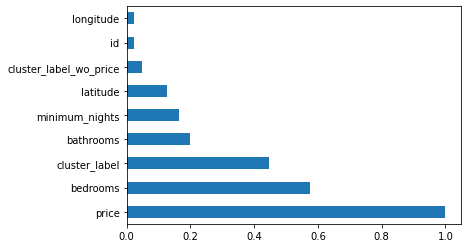

In [ ]:
corr_w_price = pd.Series(abs(corr["price"]), index=corr.columns)
corr_w_price.nlargest(20).plot(kind='barh')

Based on the above, we can actually see that the "cluster_label" which clustered based on both location coordinates and price shows a better correlation with price than just using the location coordinates themselves (see "cluster_label_wo_price").

### Machine Learning <br>
Let us build a machine learning pipeline so that we can test at least 3 different regression algorithms, and see which one is highest performing in terms of prediction accuracy. <br>

The goal is to have predictions that deviate less than $25 from the actual price. So the (root mean square deviation) should be less than 25. <br>
<br>
(1) Linear Regression           <br>
(2) Ridge Regression            - less susceptible to overfitting<br>

#### (1) Linear Regression

In [ ]:
from sklearn.linear_model import LogisticRegression, BayesianRidge    # reg = LogisticRegression()
from sklearn.linear_model import Ridge
from sklearn import linear_model
#>>> clf = linear_model.Lasso(alpha=0.1)
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder, PolynomialFeatures, FunctionTransformer

In [ ]:
#Identify predictors and target/response
X = df_2.loc[:,df_2.columns[~df_2.columns.isin(['id','price'])]]
y = df_2['price']

#preview the features that will be fed into the model, ensure it looks accurate.
X.head()

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,cluster_label,cluster_label_wo_price
0,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,3,0
1,37.75402,-122.45805,House,Private room,1.0,1.0,1,0,2
2,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,3,1
5,37.77525,-122.43637,House,Entire home/apt,1.5,2.0,6,2,0
6,37.75919,-122.42237,Condominium,Private room,1.0,1.0,1,0,0


In [ ]:
from sklearn.model_selection import train_test_split
#Identify predictors and response
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

The step below encodes the features with text values into using a OneHotEncoder. 

In [ ]:
categorical_col = ["property_type","room_type","cluster_label"]

categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

The step below normalizes/standardizes the features with numerical values so that all values range from 0 to 1, and values look like a normal distribution.
StandardScaler prevents extremely high/low values from skewing the model.

In [ ]:
numerical_col = ["latitude","longitude","bathrooms","bedrooms","minimum_nights"]

numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler())
    ]
)

In [ ]:
preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, categorical_col),
        ('numericals', numeric_transformer, numerical_col)
    ],
    remainder = 'drop'
)

In [ ]:
pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('reg', LogisticRegression())
    ]
)

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'cluster_label']),
                                                 ('numericals',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                         

In [ ]:
y_pred = pipeline.predict(X_test)

### Evaluating the Model

RMSE measures how far the predicted values are from the actual values. In this case, we do not want the predicted prices to exceed 25, so we are looking for a RMSE of 25 or less.

In [ ]:
#importing modules relevant to the 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
accuracy_summary = {"Algorithm":"Linear Regression", "R2 Score":r2_score(y_test, y_pred), "RMSE":sqrt(mean_squared_error(y_test, y_pred))}
print(accuracy_summary)

{'Algorithm': 'Linear Regression', 'R2 Score': 0.8488747546994873, 'RMSE': 54.4330654242619}


In [ ]:
column_names = ["Algorithm", "R2 Score", "RMSE", "Polynomial"]

In [ ]:
accuracy_summary_df = pd.DataFrame(columns = column_names)

In [ ]:
accuracy_summary_df = accuracy_summary_df.append(accuracy_summary, ignore_index = True)

#### Feature Importance for Linear Regression

Here's an initial look at feature importance and their respective weight for linear regression.

In [ ]:
#extract columns created during one-hot encoding and preprocessing phase
feat_columns = list(pipeline.named_steps['preprocessing'].named_transformers_['categoricals'].named_steps['onehot'].get_feature_names(input_features=categorical_col))

In [ ]:
numeric_features_list = list(numerical_col)
feat_columns.extend(numeric_features_list)

In [ ]:
#plot graph of feature importances for better visualization
feature_importance=pd.DataFrame({'feature':list(feat_columns),'feature_importance':[abs(i) for i in pipeline.named_steps['reg'].coef_[0]]})
feature_importance.sort_values('feature_importance',ascending=False).head(10)

,feature,feature_importance
28,room_type_Shared room,0.925726
25,room_type_Entire home/apt,0.617874
37,minimum_nights,0.467148
35,bathrooms,0.411492
33,latitude,0.394082
29,cluster_label_0,0.348658
1,property_type_Apartment,0.333378
34,longitude,0.310302
27,room_type_Private room,0.278627
32,cluster_label_3,0.237544


#### (2) Ridge Regression

Ridge regression is a term used to refer to a linear regression model whose coefficients are not estimated by ordinary least squares (OLS)

In [ ]:
pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('reg', Ridge(alpha=1.0)) # Ridge
    ]
) 

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'cluster_label']),
                                                 ('numericals',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                         

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
accuracy_summary = {"Algorithm":"Ridge Regression", "R2 Score":r2_score(y_test, y_pred), "RMSE":sqrt(mean_squared_error(y_test, y_pred))}

In [ ]:
print(accuracy_summary)

{'Algorithm': 'Ridge Regression', 'R2 Score': 0.9119036924043743, 'RMSE': 41.55977007028892}


In [ ]:
accuracy_summary_df = accuracy_summary_df.append(accuracy_summary, ignore_index = True)

In [ ]:
print(accuracy_summary_df)

           Algorithm  R2 Score       RMSE  Polynomial
0  Linear Regression  0.848875  54.433065         NaN
1   Ridge Regression  0.911904  41.559770         NaN


#### Feature Importance for Ridge Regression

Let us look at feature importance and their respective weight for ridge regression.

In [ ]:
#extract columns created during one-hot encoding and preprocessing phase
feat_columns = list(pipeline.named_steps['preprocessing'].named_transformers_['categoricals'].named_steps['onehot'].get_feature_names(input_features=categorical_col))

In [ ]:
numeric_features_list = list(numerical_col)
feat_columns.extend(numeric_features_list)

In [ ]:
#plot graph of feature importances for better visualization
feature_importance=pd.DataFrame({'feature':list(feat_columns),'feature_importance':[abs(i) for i in pipeline.named_steps['reg'].coef_]})
feature_importance.sort_values('feature_importance',ascending=False)

,feature,feature_importance
31,cluster_label_2,313.533168
29,cluster_label_0,224.512254
32,cluster_label_3,128.443175
30,cluster_label_1,39.422262
28,room_type_Shared room,36.554436
13,property_type_Hostel,32.260390
25,room_type_Entire home/apt,28.983861
2,property_type_Bed and breakfast,20.709496
21,property_type_Serviced apartment,18.052960
19,property_type_Other,15.713619


### Findings: Comparing Machine Learning Algorithms

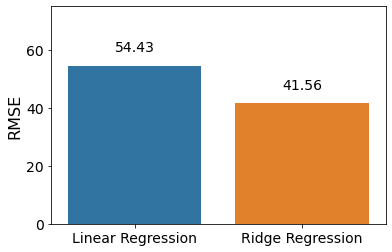

In [ ]:
plt.rcParams["axes.labelsize"] = 16

summary_plot = sns.barplot(x="Algorithm", y="RMSE", data=accuracy_summary_df)
summary_plot.set_xlabel("")

plt.ylim(0, 75)
summary_plot.tick_params(labelsize=14)
for p in summary_plot.patches:
    height = p.get_height()
    summary_plot.text(p.get_x()+p.get_width()/2., height+5, "{:1.2f}".format(height), ha="center", fontsize=14) 

plt.savefig("predict-rental-prices.png")

### Hypertuning: Ridge Regression

With ridge regression, we can hypertune based on the alpha parameter, which signifies the learning rate that we wish to choose for this machine learning algorithm.

In [ ]:
from sklearn.linear_model import Ridge

RidgeRegression = Ridge()
hyperParameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}

In [ ]:
ridgeRegressor = GridSearchCV(RidgeRegression, hyperParameters, scoring='neg_mean_squared_error', cv=5)
#ridgeRegressor.fit(X,y)

In [ ]:
pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('reg', ridgeRegressor) # Ridge
    ]
) 

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'cluster_label']),
                                                 ('numericals',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                         

In [ ]:
print("Best value for lambda : ",pipeline.named_steps['reg'].best_params_)
print("Best score for cost function: ",pipeline.named_steps['reg'].best_score_)

Best value for lambda :  {'alpha': 1}
Best score for cost function:  -1595.163109942375


Interestingly enough the hyperparameter tuning for ridge regression revealed that the initally chosen parameter of alpha=1.0 is also the optimal parameter. 

### Discussion and Next Steps

Based on the two models trained, Ridge Regression has the highest R-squared value of 0.91 and the lowest RSME value of 41.56.

i.e. 91% of the variability in rental prices can be explained using the eight features: latitude, longitude, bathrooms, bedrooms, minimum_nights, property_type, room_type, and a geographical clustering variable. 

The top three most important features are geographical clustering variable, room type, property type. 

The geographical clustering variable seems to suggest that additional information about the neighborhood would be valuable in increasing the predictive power of the models. According to conventional wisdom, different neighborhoods reflect different income levels, proximity to landmarks and tourist locations, and thereby command different nightly prices for short-term rentals. 

It is plausible to bring in information about the neighborhood from FourSquare or AirBnB data. 

The next steps would also be to obtain more data since nearly half the data was filtered out because the data reflected long-term rentals and not short-term rentals. More short-term rental data would increase model accuracy. 

And lastly, for future consideration, it may be prudent to adjust nightly rental prices with respect to off-peak tourist season vs. peak tourist season. This would allow for a apples-to-apples comparison when looking at short-term rentals.  